In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from kpsn.project.paths import Project, create_model
from kpsn.io import loaders
from kpsn.models import joint
from kpsn import config
from kpsn.models import instantiation, setup, pose, morph, util as model_util
from kpsn import fitting
from kpsn.fitting import em
from kpsn.io import alignment, features
from kpsn.io.armature import Armature
from kpsn.fitting import methods
from kpsn.fitting import scans
import os, sys, shutil
from pprint import pprint
from kpsn import viz
from kpsn.viz import styles
import matplotlib.pyplot as plt
plotter, colors = styles.init_nb("vscode_dark")

import logging
logging.getLogger().setLevel(logging.INFO)

In [3]:
project_dir = '../projects/mo-ontogeny'
project = Project(project_dir)

# if os.path.exists(project_dir): shutil.rmtree(project_dir)
if not os.path.exists(project_dir):
    loaders.raw_npy.setup_project_config(
        project,
        filepaths = {
            '24wk_m3': '../../../data_explore/data/11_03_22_24wk_m3.npy',
            '5wk_m6': '../../../data_explore/data/10_24_22_5wk_m6.npy'},
        ref_session = '24wk_m3',
        keypoint_names = [
            'shldr', 'back', 'hips', 't_base','t_tip', 'head',
            'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
            'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'],
        keypoint_parents = [
            'back', 'hips', None, 'hips', 'shldr',
            'head', 'head', 'head', 'hips', 'lr_knee',
            'hips', 'rr_knee', 'shldr', 'shldr'],
        exclude_keypoints = ['t_tip'],
        subsample = 10)
    
    setup.setup_base_model_config(project)

In [40]:
cfg = config.load_project_config(project.main_config())
dataset = loaders.raw_npy.load(cfg["dataset"])

dataset, cfg = loaders.raw_npy.default_alignment.calibrate(
    project, dataset, cfg, origin="hips", anterior="head"
)

cfg = loaders.raw_npy.default_features.calibrate(project, dataset, cfg)
dataset = loaders.raw_npy.default_features.reduce(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

cfg = config.load_model_config(project.base_model_config())

cfg = pose.gmm.calibrate_base_model(project, dataset, cfg, n_components=5)
cfg = morph.lowrank_affine.calibrate_base_model(project, dataset, cfg)
cfg = em.calibrate_base_model(project, dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

Reloading 'kpsn.viz.model'.
Reloading 'kpsn.io.features'.
Reloading 'kpsn.config'.


In [30]:
cfg = config.load_model_config(project.base_model_config())
cfg["features"]

{'type': 'locked_pts', 'reduce_ixs': [6, 7, 8, 13], 'n_kpts': 14, 'calibration_data': {}}

### Dataset / calibration plots

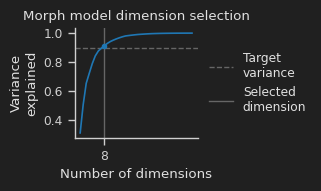

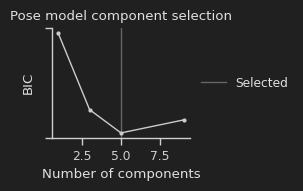

In [5]:
cfg = config.load_model_config(project.base_model_config())
calibration_plots = viz.model.plot_calibration(project, cfg)

plotter.finalize(calibration_plots["morph"], None, display = False)
plotter.finalize(calibration_plots["pose"], None, display = False)
plt.show()

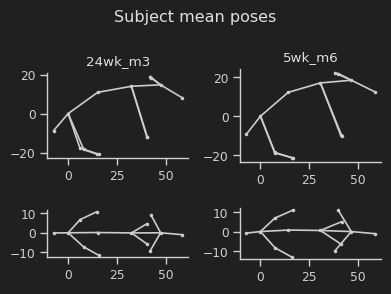

In [6]:
cfg = config.load_project_config(project.main_config())
fig = viz.general.session_means(cfg)
plotter.finalize(fig, None)

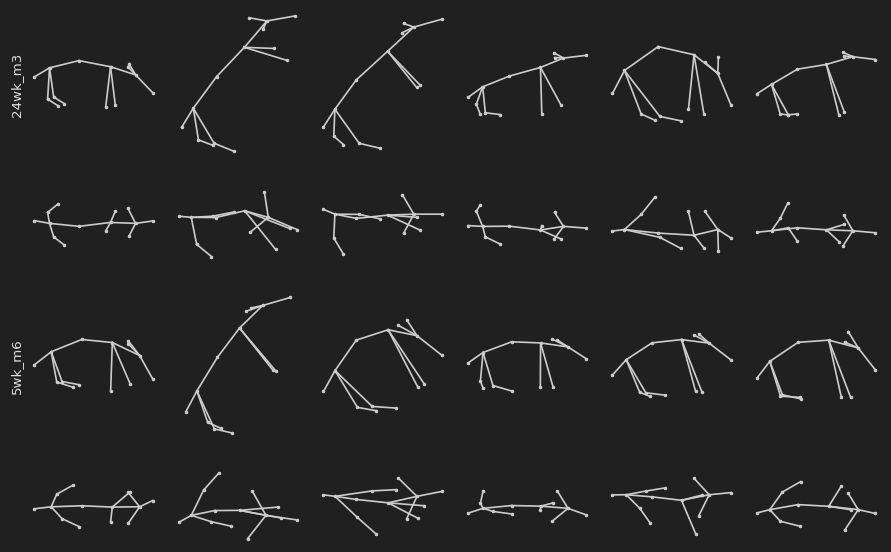

In [7]:
cfg = config.load_project_config(project.main_config())
fig = viz.general.pose_gallery(cfg)
plotter.finalize(fig, None, despine=False)

### Single model fitting

In [40]:
model_dir, cfg = create_model(project, 'first_run', {
    'fit.n_steps': 10
})

In [ ]:
model = instantiation.get_model(cfg)
params = joint.initialize_joint_model(model, dataset, cfg)

In [ ]:
model = instantiation.get_model(cfg)
cfg['fit']['mstep']['n_steps'] = 40
fit_params, fit_hist = em.iterate_em(
    model, params, dataset, cfg['fit'], log_every = 1
)

In [ ]:
fit_data = methods.fit(
    project.model('first_run'),
    log_every = 1,)

### Scan

In [28]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "prior-scan", {
    'morph.upd_var_ofs': [1e-1, 1e0, 1e1],
    'morph.upd_var_modes': [1e-2, 1e-1, 1e0],
}, model_overrides={
    'fit.learning_rate': 8,
    'fit.n_steps': 400,
})

In [29]:
scans.run_scan(project, "prior-scan", log_every=1)

INFO:root:Continuing from checkpoint at step 99.
INFO:root:Adjusting learning rate:8 -> 0.0011134307585247043
INFO:root:Loading LR schedule: const
INFO:root:Step 100 : loss = 537428.9375
INFO:root:Step 101 : loss = 537431.8125
INFO:root:Step 102 : loss = 537428.5625
INFO:root:Step 103 : loss = 537424.4375
INFO:root:Step 104 : loss = 537421.4375
INFO:root:Step 105 : loss = 537416.375
INFO:root:Step 106 : loss = 537415.4375
INFO:root:Step 107 : loss = 537410.75
INFO:root:Step 108 : loss = 537407.875
INFO:root:Step 109 : loss = 537408.6875
INFO:root:Step 110 : loss = 537405.5
INFO:root:Step 111 : loss = 537406.6875
INFO:root:Step 112 : loss = 537403.3125
INFO:root:Step 113 : loss = 537397.0
INFO:root:Step 114 : loss = 537400.1875
INFO:root:Step 115 : loss = 537396.5625
INFO:root:Step 116 : loss = 537398.5625
INFO:root:Step 117 : loss = 537396.9375
INFO:root:Step 118 : loss = 537391.9375
INFO:root:Step 119 : loss = 537390.5
INFO:root:Step 120 : loss = 537391.125
INFO:root:Step 121 : loss =

##### convergence checks

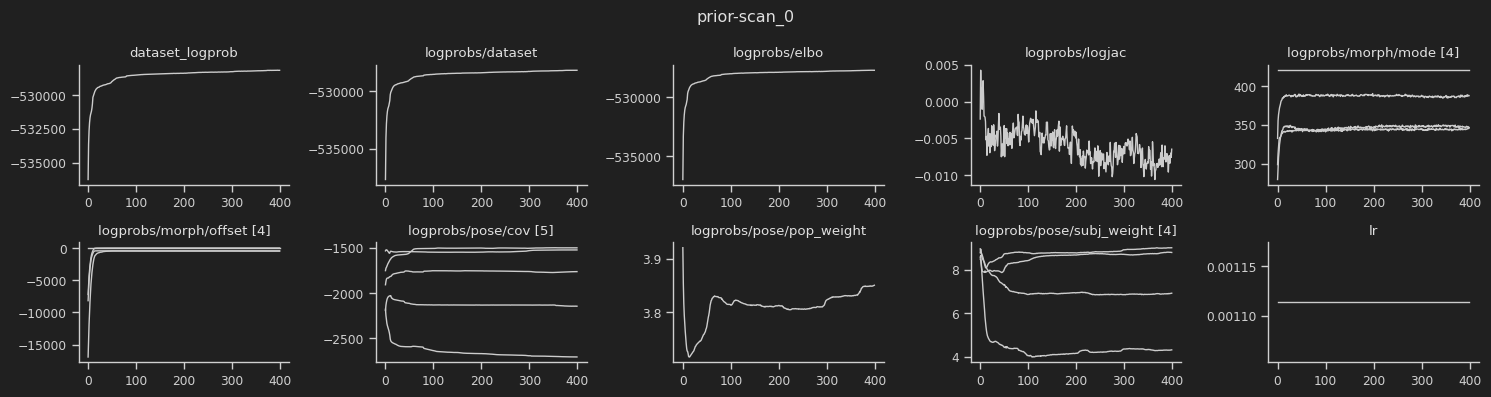

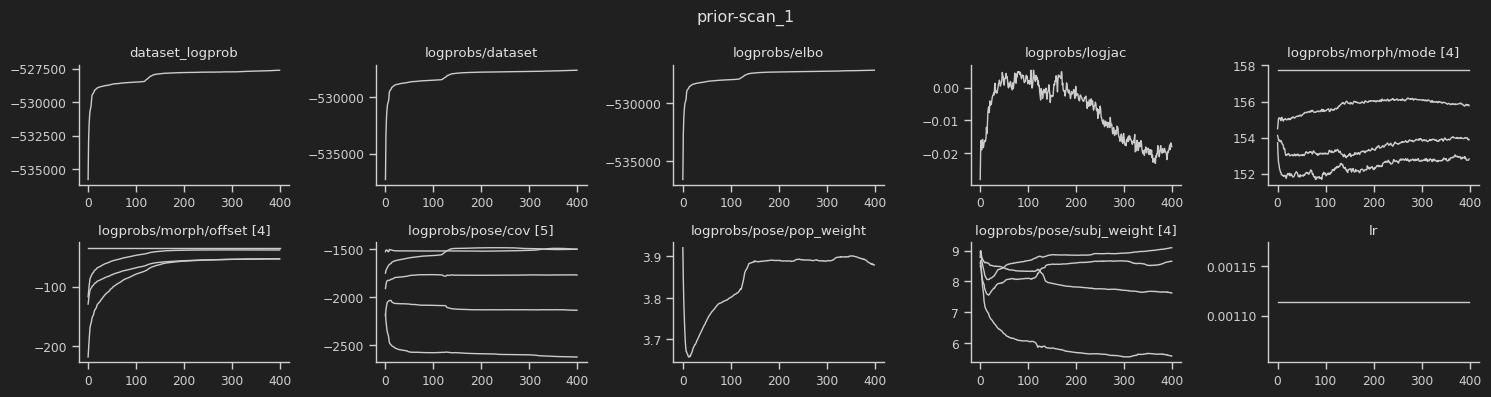

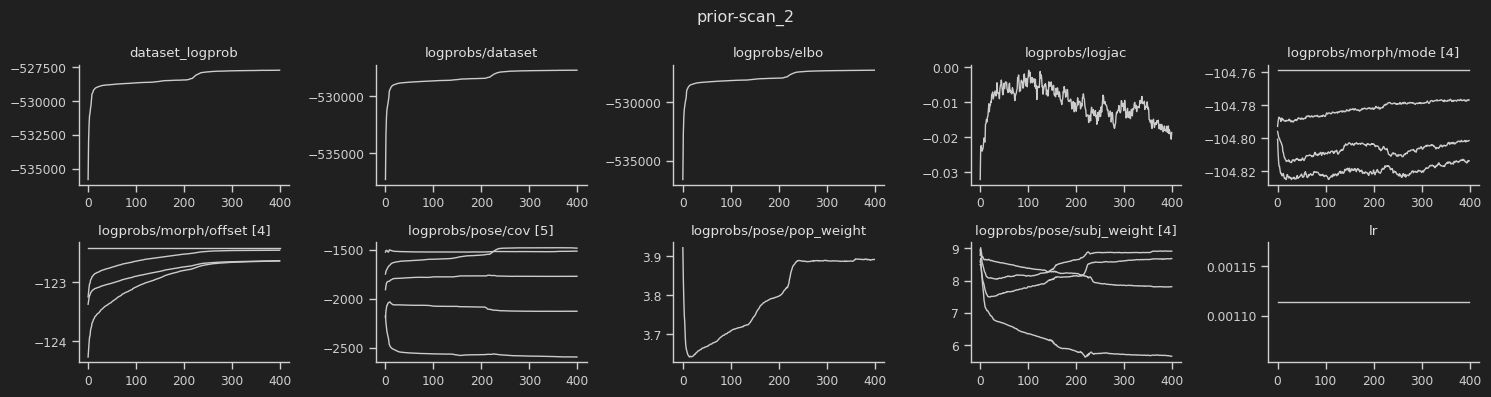

In [30]:
scan_cfg = config.load_config(project.scan("prior-scan") / "scan.yml")
for model_name in scan_cfg["models"]:
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz.model.report_plots(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, None)

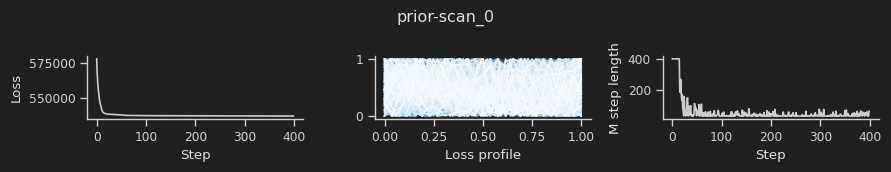

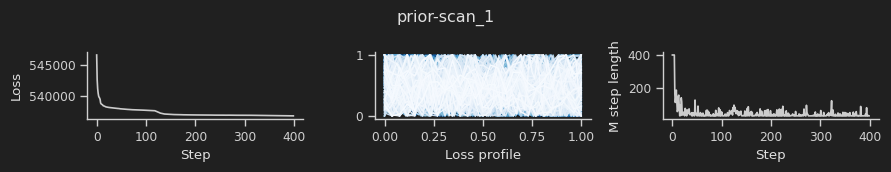

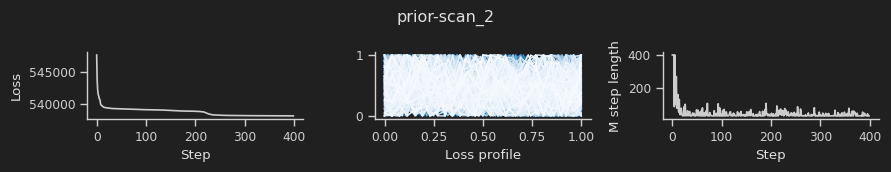

In [31]:
scan_cfg = config.load_config(project.scan("prior-scan") / "scan.yml")
for model_name in scan_cfg["models"]:
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, None)

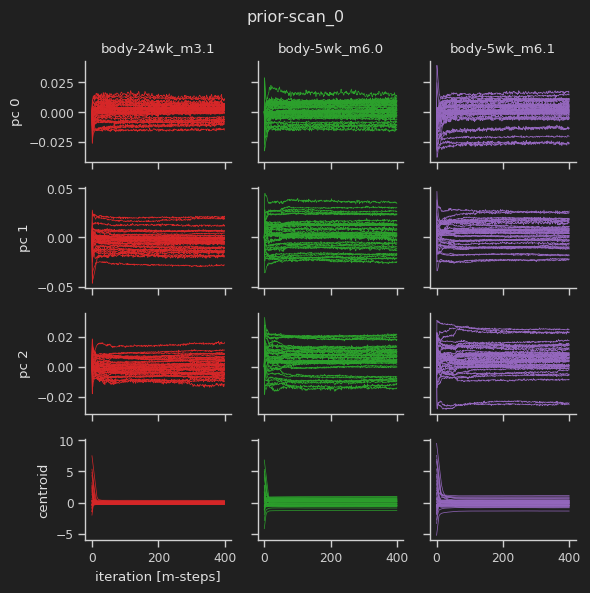

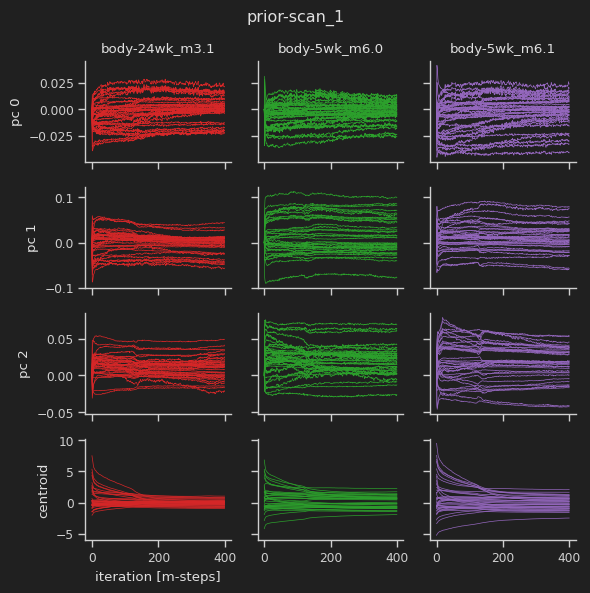

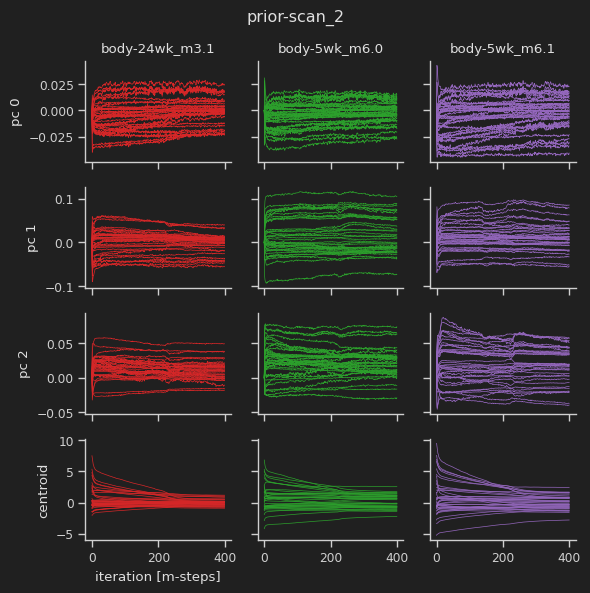

In [32]:
scan_cfg = config.load_config(project.scan("prior-scan") / "scan.yml")
for model_name in scan_cfg["models"]:
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz.model.lra_param_convergence(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, None)

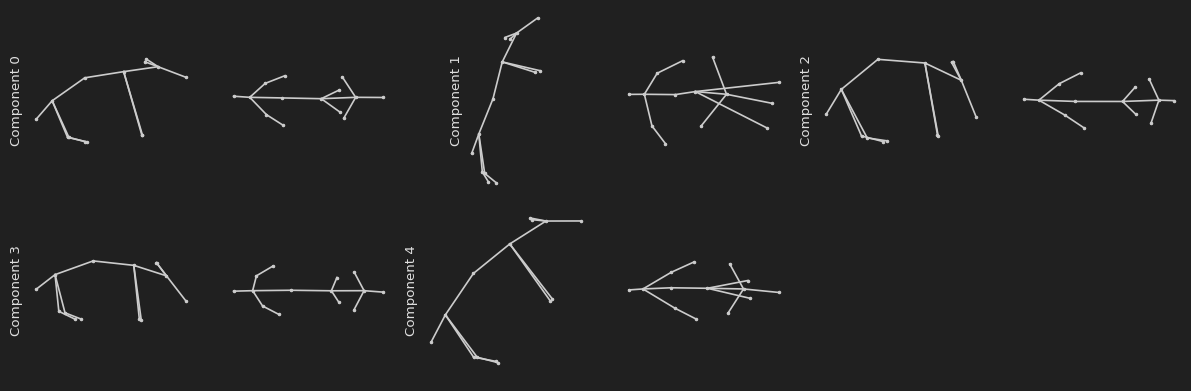

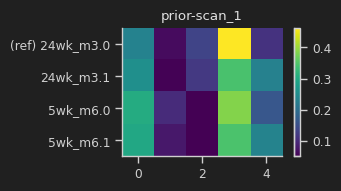

In [15]:
model_name = 'prior-scan_1'
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
arm = Armature.from_config(cfg['dataset'])
_dataset, _, _inflate = scans._dataset_and_bodies_inv(project, model_name)
params = ckpt["params"].pose

fig, ax, ax_grid = viz.util.flat_grid(params.n_components * 2, 6, (2, 2))
for i in range(params.n_components):
    pose = _inflate(params.means[i:i+1])[0]
    viz.util.plot_mouse_views(ax[i * 2 : (i + 1) * 2], pose, arm, color = colors.neutral)
    ax[i * 2].set_ylabel(f"Component {i}")

for a in ax:
    viz.util.axes_off(a)
plotter.finalize(fig, None, despine=False)

fig, ax = plt.subplots(figsize = (3.5, 2))
plt.imshow(ckpt["params"].pose.subj_weights)
ax.set_yticks(range(len(_dataset.sessions)))
ax.set_yticklabels([
    ("(ref) " if _dataset._session_names[i] == _dataset.ref_session else "") + _dataset._session_names[i]
    for i in range(len(_dataset.sessions))])
ax.set_title(model_name)
plt.colorbar()
plotter.finalize(fig, None)

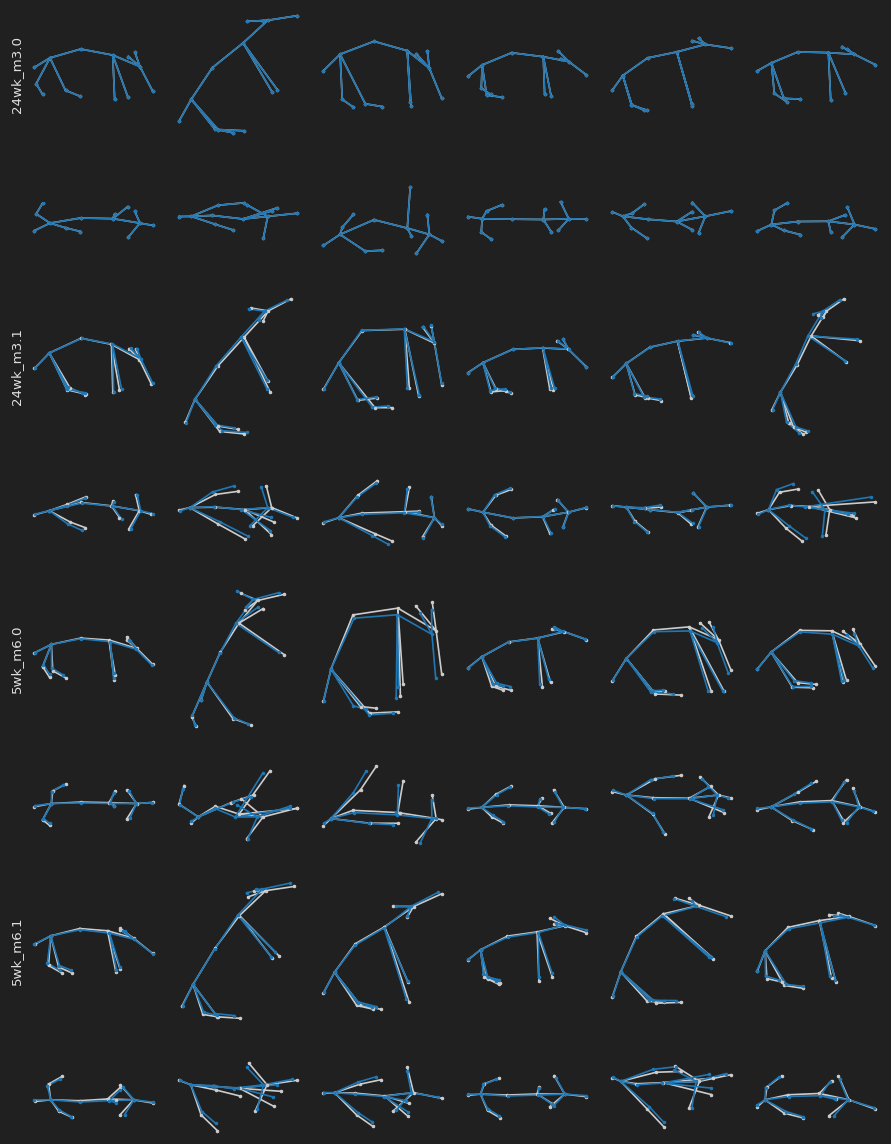

In [33]:
model_name = 'prior-scan_1'
cfg = config.load_model_config(project.model_config(model_name))
dataset, _body_inv, _inflate = scans._dataset_and_bodies_inv(project, model_name)
model = instantiation.get_model(cfg)
checkpoint = methods.load_fit(project.model(model_name))
arm = Armature.from_config(cfg['dataset'])

# transform all sessions to the global reference session's body


ref_body = dataset.sess_bodies[dataset.ref_session]
mapped_reduced = model_util.apply_bodies(
    model.morph,
    checkpoint["params"].morph,
    dataset,
    {s: ref_body for s in dataset.sessions},
)
aligned = _inflate(dataset)
mapped = _inflate(mapped_reduced)


fig, ax = plt.subplots(2 * dataset.n_sessions, 6, figsize = (1.5 * 6, 3 * dataset.n_sessions))

for i, s in enumerate(dataset.sessions):

    gallery_ixs = viz.util.select_frame_gallery(aligned.get_session(s), arm, return_ixs=True, as_list=True)
    orig_poses = aligned.get_session(s)[gallery_ixs]
    mapped_poses = mapped.get_session(s)[gallery_ixs]

    for j, (orig_pose, mapped_pose) in enumerate(zip(orig_poses, mapped_poses)):
        a = ax[2 * i : 2 * (i + 1), j]
        viz.util.plot_mouse_views(a, orig_pose, arm, color = colors.neutral)
        viz.util.plot_mouse_views(a, mapped_pose, arm, color = colors.C[0])
    
    ax[2 * i, 0].set_ylabel(s)

viz.util.axes_off(ax)

plotter.finalize(fig, None, despine=False)


Reloading 'kpsn.models.morph.lowrank_affine'.
Reloading 'kpsn.viz.util'.
Reloading 'kpsn.io.loaders'.
Reloading 'kpsn.models.pose.gmm'.
Reloading 'kpsn.viz.model'.
Reloading 'kpsn.config'.


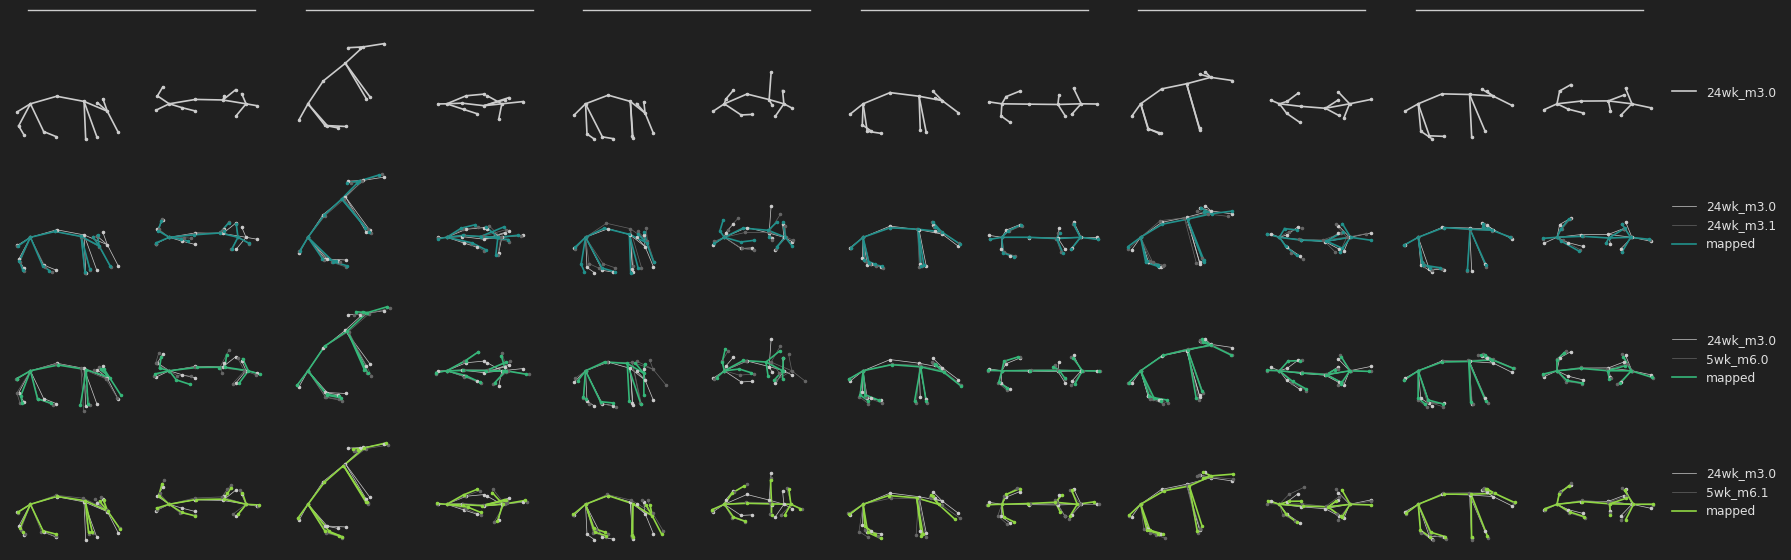

In [42]:
ckpt = methods.load_fit(project.model("prior-scan_1"))
fig = viz.model.compare_nearest_frames(ckpt, group_lines=True)
plotter.finalize(fig, None, despine = False, tight=False)

##### scan plots

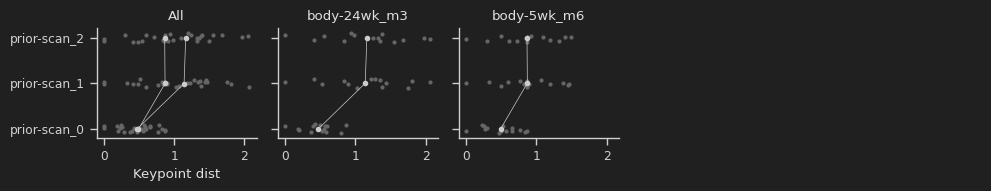

In [34]:
fig = viz.scans.withinbody_reconst_errs(project, "prior-scan")
plotter.finalize(fig, None)

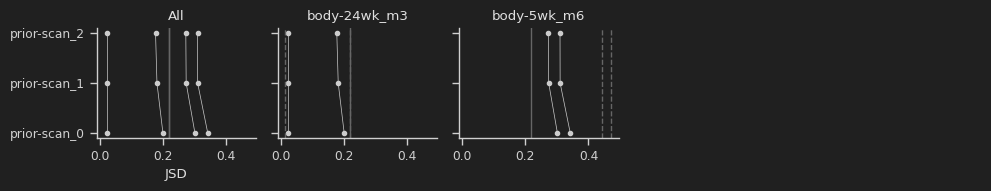

In [35]:
fig = viz.scans.jsds_to_reference(project, "prior-scan")
plotter.finalize(fig, None)